# Architecture Playground
This notebook is a duplicate of `4 Load Images into Memory`. The end goal is to increase accuracy by tinkering with the architecture of the CNN.
This was initially supposed to be architecture playground, but it is now optimizer playground.

#### Imports and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 4

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import optimizers

In [2]:
def plot_figures(figures, nrows=1, ncols=1, size=8):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(size,size))
    for ind,title in enumerate(figures):
        axeslist[ind].imshow(figures[title], cmap=plt.gray())
        axeslist[ind].set_title(title)
        axeslist[ind].set_axis_off()
    plt.tight_layout() # optional
    
def plot_train_history(history):
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Load in all images
We have enough memory :)

In [3]:
x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

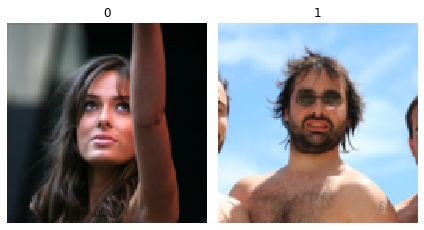

In [4]:
figures = {'0': x_train[0], '1': x_train[1]}
plot_figures(figures, 1, 2, 6)

# Current Best (standardized, bilinear) - val_acc: 0.5235 (100 epochs)
We will use the same model architecture as the previous notebook, 4-Class-CNN. We just want to make sure everything is working as expected and test the speed improvements from using images in RAM

#### Verify that it works
Looks good. The mean should be closer to 0 ideally though

In [21]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(x_train)
# print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))
iterator = datagen.flow(x_train, y_train, batch_size=64)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())


iterator = datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())

(64, 128, 128, 3) 0.9526761 1.1246042
(8000, 128, 128, 3) 1.0059751 1.0923867


#### Define Train function

In [6]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [21]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(4),   # number of classes is 4
    Activation('softmax')
])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_28 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_29 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)       

#### Execute Training

In [32]:
history, model = train(model_1)

Epoch 1/100
63/63 [==============================] - 6s 88ms/step - loss: 2.2720 - acc: 0.2587 - val_loss: 1.4177 - val_acc: 0.2303
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 2.0924 - acc: 0.2623 - val_loss: 1.4171 - val_acc: 0.2477
Epoch 3/100
63/63 [==============================] - 5s 72ms/step - loss: 2.0622 - acc: 0.2585 - val_loss: 1.4226 - val_acc: 0.2598
Epoch 4/100
63/63 [==============================] - 5s 72ms/step - loss: 2.0578 - acc: 0.2627 - val_loss: 1.4313 - val_acc: 0.2659
Epoch 5/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0376 - acc: 0.2587 - val_loss: 1.4408 - val_acc: 0.2909
Epoch 6/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0179 - acc: 0.2680 - val_loss: 1.4519 - val_acc: 0.2886
Epoch 7/100
63/63 [==============================] - 4s 71ms/step - loss: 1.9888 - acc: 0.2699 - val_loss: 1.4630 - val_acc: 0.2902
Epoch 8/100
63/63 [==============================] - 4s 71ms/step - loss: 1.

Epoch 62/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6515 - acc: 0.3529 - val_loss: 1.2217 - val_acc: 0.4621
Epoch 63/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6234 - acc: 0.3619 - val_loss: 1.2084 - val_acc: 0.4659
Epoch 64/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6270 - acc: 0.3649 - val_loss: 1.2023 - val_acc: 0.4689
Epoch 65/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6122 - acc: 0.3627 - val_loss: 1.1982 - val_acc: 0.4705
Epoch 66/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6368 - acc: 0.3568 - val_loss: 1.1964 - val_acc: 0.4735
Epoch 67/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6317 - acc: 0.3647 - val_loss: 1.1927 - val_acc: 0.4795
Epoch 68/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6086 - acc: 0.3747 - val_loss: 1.1908 - val_acc: 0.4788
Epoch 69/100
63/63 [==============================] - 5s 72ms/step - 

# New Optimizers

## Model 1: Deeper - 0.5803 (100 epochs)
Take the past model and make it deeper.

#### Define Train function

In [24]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
    return history, model

#### Define Model
Made it deeper and added a Dense(1024) layer at the end

In [25]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_16 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_17 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 7s 108ms/step - loss: 1.8392 - acc: 0.2564 - val_loss: 1.3917 - val_acc: 0.2402
Epoch 2/100
63/63 [==============================] - 5s 77ms/step - loss: 1.7599 - acc: 0.2554 - val_loss: 1.4010 - val_acc: 0.2462
Epoch 3/100
63/63 [==============================] - 5s 78ms/step - loss: 1.7670 - acc: 0.2501 - val_loss: 1.4119 - val_acc: 0.2568
Epoch 4/100
63/63 [==============================] - 5s 80ms/step - loss: 1.7276 - acc: 0.2679 - val_loss: 1.4194 - val_acc: 0.2614
Epoch 5/100
63/63 [==============================] - 5s 81ms/step - loss: 1.6929 - acc: 0.2720 - val_loss: 1.4236 - val_acc: 0.2606
Epoch 6/100
63/63 [==============================] - 5s 82ms/step - loss: 1.6861 - acc: 0.2755 - val_loss: 1.4158 - val_acc: 0.2659
Epoch 7/100
63/63 [==============================] - 5s 77ms/step - loss: 1.6768 - acc: 0.2804 - val_loss: 1.4047 - val_acc: 0.2932
Epoch 8/100
63/63 [==============================] - 5s 76ms/step - loss: 1

63/63 [==============================] - 5s 77ms/step - loss: 1.3508 - acc: 0.3940 - val_loss: 1.1944 - val_acc: 0.5371
Epoch 63/100
63/63 [==============================] - 5s 77ms/step - loss: 1.3347 - acc: 0.4130 - val_loss: 1.1914 - val_acc: 0.5402
Epoch 64/100
63/63 [==============================] - 5s 77ms/step - loss: 1.3311 - acc: 0.4071 - val_loss: 1.1901 - val_acc: 0.5409
Epoch 65/100
63/63 [==============================] - 5s 76ms/step - loss: 1.3221 - acc: 0.4156 - val_loss: 1.1879 - val_acc: 0.5447
Epoch 66/100
63/63 [==============================] - 5s 77ms/step - loss: 1.3291 - acc: 0.4195 - val_loss: 1.1849 - val_acc: 0.5477
Epoch 67/100
63/63 [==============================] - 5s 76ms/step - loss: 1.3163 - acc: 0.4125 - val_loss: 1.1830 - val_acc: 0.5439
Epoch 68/100
63/63 [==============================] - 5s 78ms/step - loss: 1.3151 - acc: 0.4198 - val_loss: 1.1810 - val_acc: 0.5470
Epoch 69/100
63/63 [==============================] - 5s 77ms/step - loss: 1.3198 

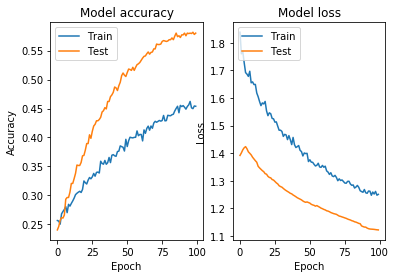

In [27]:
# opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
history, model_1 = train(model_1)

## Model 2: Change Optimizer From adadelta to adagrad - 0.9515 (epoch 46)


#### Define Train function

In [21]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
        
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(val_acc[index], index+1))
    return history, model

#### Define Model

In [22]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_9 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100


W0823 13:50:34.241590 16608 deprecation.py:506] From C:\Users\kendy\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


63/63 [==============================] - 7s 111ms/step - loss: 1.3893 - acc: 0.4900 - val_loss: 0.9586 - val_acc: 0.6485
Epoch 2/100
63/63 [==============================] - 5s 78ms/step - loss: 0.9926 - acc: 0.5984 - val_loss: 0.8767 - val_acc: 0.6667
Epoch 3/100
63/63 [==============================] - 5s 78ms/step - loss: 0.8811 - acc: 0.6454 - val_loss: 0.8201 - val_acc: 0.6970
Epoch 4/100
63/63 [==============================] - 5s 78ms/step - loss: 0.7901 - acc: 0.6901 - val_loss: 0.7518 - val_acc: 0.7250
Epoch 5/100
63/63 [==============================] - 5s 78ms/step - loss: 0.7082 - acc: 0.7245 - val_loss: 0.6753 - val_acc: 0.7606
Epoch 6/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6207 - acc: 0.7640 - val_loss: 0.6173 - val_acc: 0.7750
Epoch 7/100
63/63 [==============================] - 5s 78ms/step - loss: 0.5720 - acc: 0.7761 - val_loss: 0.5436 - val_acc: 0.8038
Epoch 8/100
63/63 [==============================] - 5s 78ms/step - loss: 0.5001 - acc:

62/63 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9910
Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
63/63 [==============================] - 5s 80ms/step - loss: 0.0386 - acc: 0.9910 - val_loss: 0.1574 - val_acc: 0.9447
Epoch 59/100
63/63 [==============================] - 5s 78ms/step - loss: 0.0381 - acc: 0.9885 - val_loss: 0.1559 - val_acc: 0.9455
Epoch 60/100
63/63 [==============================] - 5s 77ms/step - loss: 0.0364 - acc: 0.9904 - val_loss: 0.1558 - val_acc: 0.9462
Epoch 61/100
63/63 [==============================] - 5s 78ms/step - loss: 0.0389 - acc: 0.9898 - val_loss: 0.1547 - val_acc: 0.9470
Epoch 62/100
62/63 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9898
Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
63/63 [==============================] - 5s 77ms/step - loss: 0.0377 - acc: 0.9898 - val_loss: 0.1541 - val_acc: 0.9470
Epoch 63/100
63/63 [===========

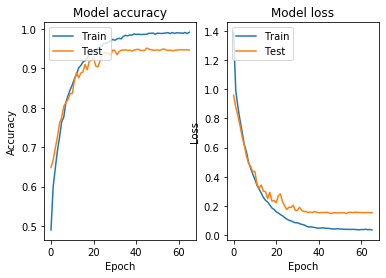

In [28]:
opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)   # default settings
# opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
history, model_1 = train(model_1, opt=opt)

In [42]:
index = history.history['val_acc'].index(max(history.history['val_acc']))
print('Best val_acc - {:.4} (epoch {:})'.format(val_acc[index], index+1))

Best val_acc - 0.9515 (epoch 46)


## Model 3: Change Optimizer from adagrad to SGD - 0.9455 (epoch 52)


#### Define Train function

In [43]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
        
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(val_acc[index], index+1))
    return history, model

#### Define Model

In [44]:
model_3 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_24 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_25 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 6s 99ms/step - loss: 1.9739 - acc: 0.3121 - val_loss: 1.3818 - val_acc: 0.2765
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 1.2495 - acc: 0.4336 - val_loss: 1.3624 - val_acc: 0.3000
Epoch 3/100
63/63 [==============================] - 5s 76ms/step - loss: 1.1360 - acc: 0.5167 - val_loss: 1.3205 - val_acc: 0.4076
Epoch 4/100
63/63 [==============================] - 5s 76ms/step - loss: 1.0389 - acc: 0.5673 - val_loss: 1.2549 - val_acc: 0.5068
Epoch 5/100
63/63 [==============================] - 5s 75ms/step - loss: 0.9563 - acc: 0.6101 - val_loss: 1.1911 - val_acc: 0.5311
Epoch 6/100
63/63 [==============================] - 5s 76ms/step - loss: 0.8996 - acc: 0.6392 - val_loss: 1.0571 - val_acc: 0.6212
Epoch 7/100
63/63 [==============================] - 5s 76ms/step - loss: 0.8541 - acc: 0.6581 - val_loss: 0.9681 - val_acc: 0.6492
Epoch 8/100
63/63 [==============================] - 5s 76ms/step - loss: 0.

63/63 [==============================] - 5s 77ms/step - loss: 0.1286 - acc: 0.9554 - val_loss: 0.2023 - val_acc: 0.9348
Epoch 60/100
62/63 [============================>.] - ETA: 0s - loss: 0.1301 - acc: 0.9574
Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
63/63 [==============================] - 5s 76ms/step - loss: 0.1302 - acc: 0.9576 - val_loss: 0.1994 - val_acc: 0.9311
Epoch 61/100
63/63 [==============================] - 5s 77ms/step - loss: 0.1222 - acc: 0.9594 - val_loss: 0.2008 - val_acc: 0.9311
Epoch 62/100
63/63 [==============================] - 5s 77ms/step - loss: 0.1228 - acc: 0.9595 - val_loss: 0.2063 - val_acc: 0.9341
Epoch 63/100
63/63 [==============================] - 5s 76ms/step - loss: 0.1182 - acc: 0.9615 - val_loss: 0.2021 - val_acc: 0.9341
Epoch 64/100
62/63 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9564
Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
63/63 [============

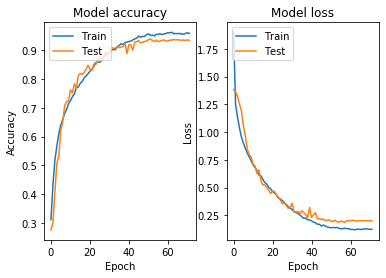

Best val_acc - 0.9455 (epoch 52)


In [45]:
# opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)   # default settings
opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
history, model_3 = train(model_3, opt=opt)

## Model 4: Adam Optimizer


#### Define Train function

In [46]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='sgd', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
        
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'], index+1))
    return history, model

#### Define Model

In [52]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_49 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 120ms/step - loss: 2.9896 - acc: 0.3873 - val_loss: 1.3847 - val_acc: 0.2553
Epoch 2/100
63/63 [==============================] - 5s 79ms/step - loss: 1.1223 - acc: 0.5374 - val_loss: 1.3792 - val_acc: 0.3008
Epoch 3/100
63/63 [==============================] - 5s 79ms/step - loss: 0.9594 - acc: 0.6045 - val_loss: 1.3068 - val_acc: 0.4538
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.8058 - acc: 0.6719 - val_loss: 1.1811 - val_acc: 0.5053
Epoch 5/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6880 - acc: 0.7201 - val_loss: 1.0537 - val_acc: 0.5508
Epoch 6/100
63/63 [==============================] - 5s 77ms/step - loss: 0.5774 - acc: 0.7755 - val_loss: 0.9371 - val_acc: 0.6152
Epoch 7/100
63/63 [==============================] - 5s 79ms/step - loss: 0.4663 - acc: 0.8213 - val_loss: 0.6642 - val_acc: 0.7470
Epoch 8/100
63/63 [==============================] - 5s 77ms/step - loss: 0

62/63 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9985
Epoch 00055: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
63/63 [==============================] - 5s 79ms/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.0950 - val_acc: 0.9689
Epoch 56/100
63/63 [==============================] - 5s 78ms/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.1112 - val_acc: 0.9697
Epoch 57/100
63/63 [==============================] - 5s 79ms/step - loss: 0.0068 - acc: 0.9987 - val_loss: 0.1105 - val_acc: 0.9689
Epoch 58/100
63/63 [==============================] - 5s 80ms/step - loss: 0.0069 - acc: 0.9985 - val_loss: 0.1112 - val_acc: 0.9689
Epoch 59/100
63/63 [==============================] - 5s 79ms/step - loss: 0.0076 - acc: 0.9989 - val_loss: 0.1008 - val_acc: 0.9697
Epoch 60/100
62/63 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9983
Epoch 00060: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
63/63 [============

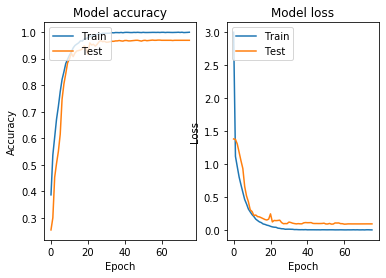

Best val_acc - 0.9455 (epoch 56)


In [53]:
# opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)   # default settings
# opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

# Results
The fastest optimizer was Adam, achieving a val_acc of 0.9682 at epoch 28.
The best performing optimizer is also Adam, with a val_acc of 0.9697 at epoch 56 :)